In [45]:
%pip install fastbook

Note: you may need to restart the kernel to use updated packages.


In [46]:
from fastcore.all import *
from fastbook import *
from fastdownload import download_url

url = search_images_ddg('toy gun', max_images=1)

dest = 'test_toy.jpg'
download_url(url[0], dest)

Path('test_toy.jpg')

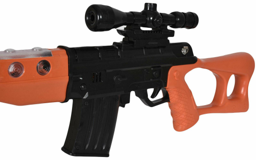

In [47]:
from fastai.vision.all import *

test_image = Image.open(dest)
test_image.to_thumb(256, 256)

In [79]:
labels = 'paintball', 'real', 'toy'
num_images = 100

path = Path('weapon_images')

for x in labels:
    dest = (path/x)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f"{x} gun", max_images=num_images))

In [80]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

In [81]:
guns = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 10),
    get_y = parent_label,
    item_tfms=Resize(256)
)

dls = guns.dataloaders(path)

/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


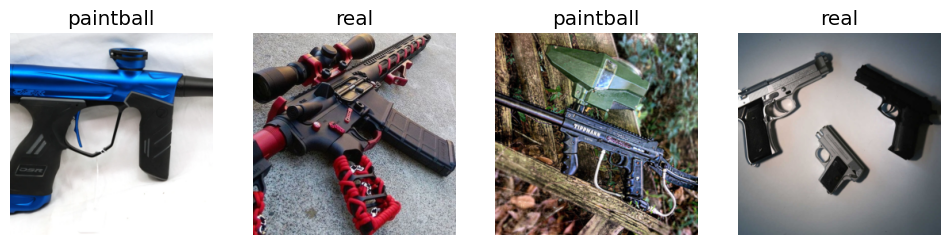

In [82]:
dls.valid.show_batch(max_n=4, nrows=1)

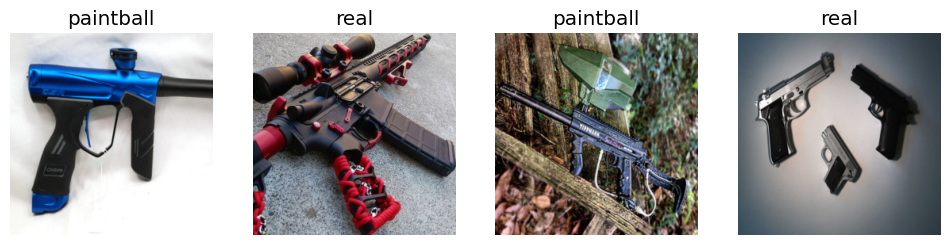

In [83]:
guns = guns.new(item_tfms=Resize(256, ResizeMethod.Squish))
dls = guns.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

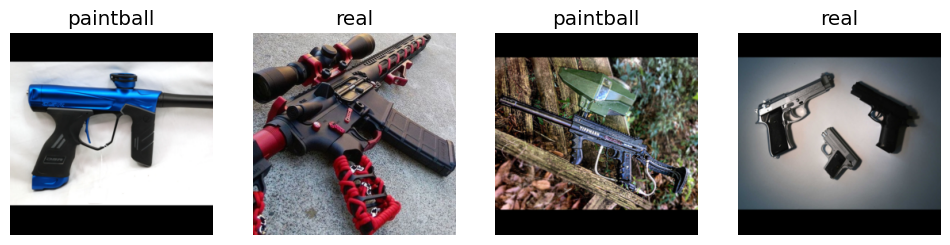

In [84]:
guns = guns.new(item_tfms=Resize(256, ResizeMethod.Pad, pad_mode='zeros'))
dls = guns.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

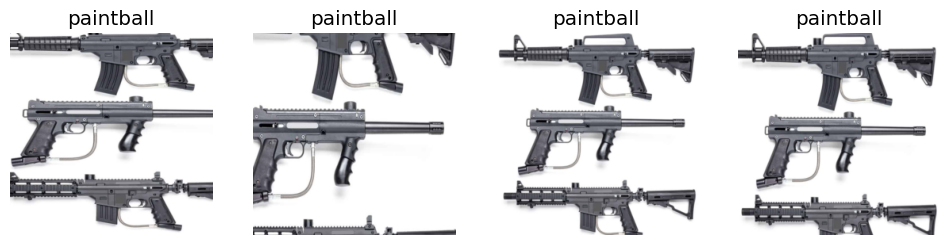

In [85]:
guns = guns.new(item_tfms=RandomResizedCrop(256, min_scale=0.3))
dls = guns.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

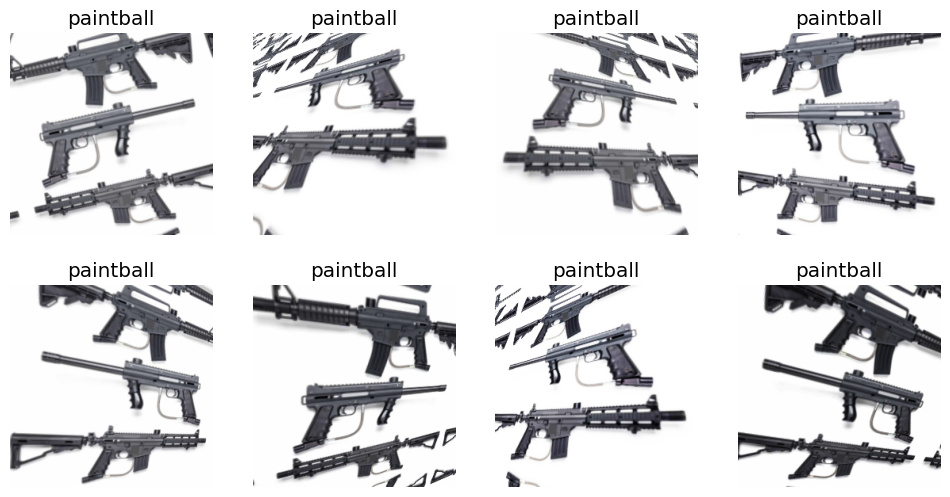

In [86]:
guns = guns.new(item_tfms=Resize(256), batch_tfms=aug_transforms(mult=2))
dls = guns.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [87]:
guns = guns.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms()
)

dls = guns.dataloaders(path)

In [88]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.638581,0.730477,0.618182,00:08


epoch,train_loss,valid_loss,accuracy,time
0,1.019314,0.497775,0.763636,00:07
1,0.933679,0.414264,0.818182,00:07
2,0.852689,0.347833,0.836364,00:07
3,0.773930,0.300157,0.872727,00:07


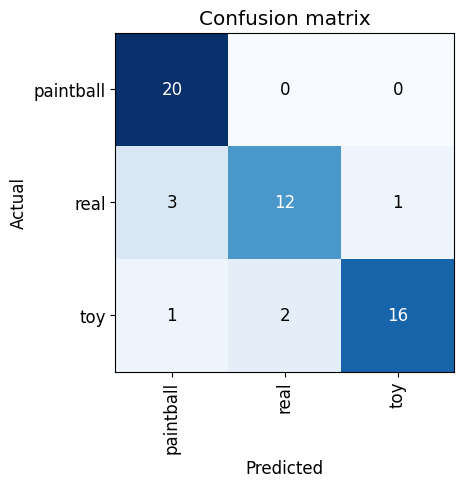

In [89]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

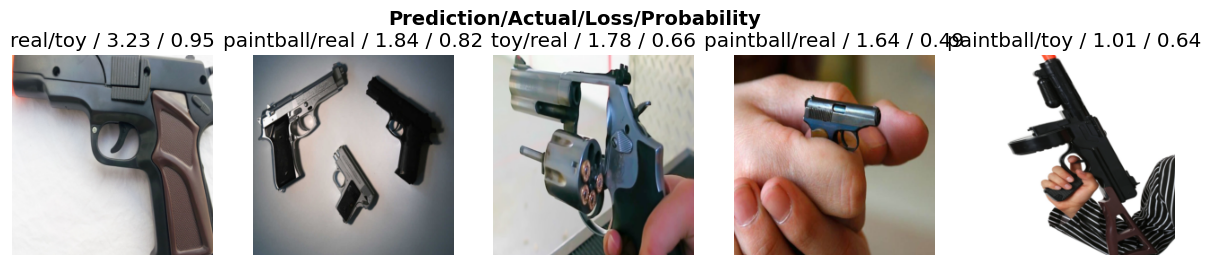

In [90]:
interp.plot_top_losses(5, nrows=1)

In [93]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [94]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [95]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.438511,0.267339,0.890909,00:13


/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.515415,0.223774,0.909091,00:07
1,0.504121,0.167074,0.945455,00:06
2,0.482933,0.145898,0.963636,00:06
3,0.432956,0.142188,0.945455,00:10


/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/abhay/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


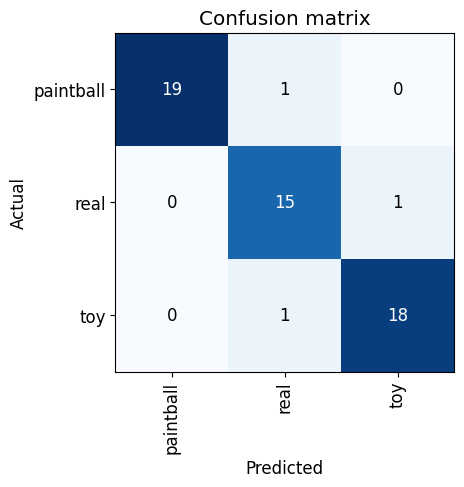

In [98]:
interp.plot_confusion_matrix()

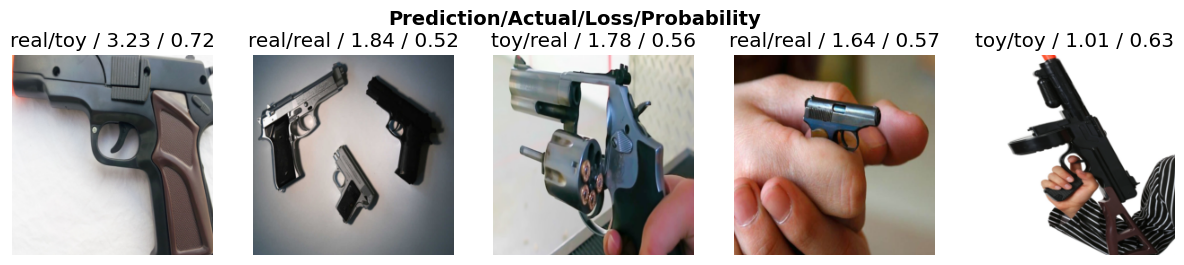

In [99]:
interp.plot_top_losses(5, nrows=1)

In [100]:
learn.export()

In [104]:
learn_inf = load_learner('export.pkl')
learn_inf.predict('test_toy.jpg')

('toy', tensor(2), tensor([4.6720e-03, 7.0484e-04, 9.9462e-01]))

In [105]:
learn_inf.dls.vocab

['paintball', 'real', 'toy']

In [106]:
label, _, probs = learn_inf.predict('test_toy.jpg')

print(f"Confidence in this image being a {label}: {probs.max() * 100}%")

Confidence in this image being a toy: 99.46231842041016%
